In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
from distributed import LocalCluster, Client

In [2]:
%matplotlib inline

In [7]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [3]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/letkf_forecasting/sat_15_good.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
wind_15_smooth = xr.open_dataset('/home/travis/python_code/letkf_forecasting/wind_15_smooth.nc')
wind_15_ave = xr.open_dataset('/home/travis/python_code/letkf_forecasting/wind_15_ave.nc')
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [4]:
# Better Crop should write as a function into letkf_forecasting
long_min = sensor_loc['lon'].min()
long_max = sensor_loc['lon'].max()
lat_min = sensor_loc['lat'].min()
lat_max = sensor_loc['lat'].max()
long = sat_15.long.values
lat = sat_15.lat.values
min_x = abs(long[0, :] - long_min).argmin()
max_x = abs(long[0, :] - long_max).argmin()
min_y = abs(lat[:, 0] - lat_min).argmin()
max_y = abs(lat[:, 0] - lat_max).argmin()

U_max = wind_15.U.max() # know U is positive
V_max = abs(wind_15.V.min()) # know V is negative

left = int(U_max*60*30/250) + 20
right = 20

up = int(V_max*60*30/250) + 20
down = 20

x_crop = slice(min_x - left, max_x + right)
y_crop = slice(min_y - down, max_y + up)
print('X length: ' + 
      str(max_x + right - (min_x - left)))
print('Y length: ' + 
      str(max_y + up - (min_y - down)))

X length: 469
Y length: 330


In [5]:
n_workers = 20
cluster = LocalCluster(n_workers=n_workers, scheduler_port=7001, diagnostics_port=7002)
client = Client(cluster)

In [16]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 5 #was 5
localization = 30
sat_inflation = 1.1
sensor_inflation = 1.5

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.15 #0.01 #0.05
sensor_sig = 0.01 #0.1 #0.05
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

analysis, analysis_error, background, background_error, advected, time_range = lf.main(
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, sensor_inflation=sensor_inflation,
    sat_inflation=sat_inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

time_index: 0
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 1
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 2
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 3
advection_number: 0
advection_number: 1
advection_number: 2


In [69]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 0.7
assimilation_grid_size = 50 #was 5
localization = 30
sat_inflation = 1.1
sensor_inflation = 1.5

CI_localization = .2
sat_oi_inflation = 10

goes15_azimuth = 220.5
goes15_elevation = 44.1

sat_sig = 0.15 #0.01 #0.05
sensor_sig = 0.01 #0.1 #0.05
ens_size = 20
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')

cloud_height = 8222

start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

analysis, analysis_error, background, background_error, advected, time_range = lf.main_oi(
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, sensor_inflation=sensor_inflation,
    sat_inflation=sat_inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    CI_localization=CI_localization, sat_oi_inflation=sat_oi_inflation,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

time_index: 0
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 1
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 2
advection_number: 0
advection_number: 1
advection_number: 2
time_index: 3
advection_number: 0
advection_number: 1
advection_number: 2


In [60]:
np.eye(27).dot(sensor_CI.ix['2014-04-15 12:00'] - np.ones(27))

array([-0.02441702,  0.0055381 ,  0.03252105,  0.0271684 ,  0.03706768,
        0.01633493,  0.00247817,  0.01543402,  0.01810145,  0.0173697 ,
        0.02880513, -0.13379307, -0.08240448,  0.00313823, -0.07663491,
       -0.00160962, -0.26883688,  0.01653063, -0.37121988, -0.17469231,
       -0.08667276, -0.23583054, -0.10373345, -0.12396548, -0.15012112,
       -0.0840172 , -0.15008342])

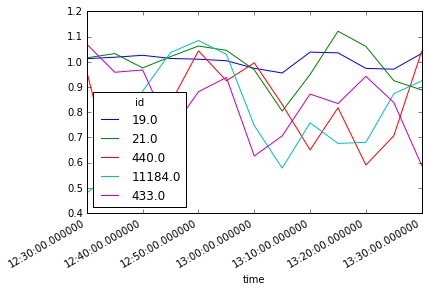

In [70]:
plt.figure()
sensor_CI[sensor_loc[sensor_loc.test==True].id].ix['2014-04-15 12:30' : '2014-04-15 13:30'].plot()

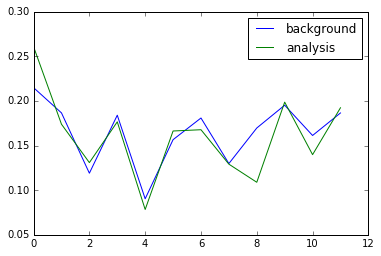

In [71]:
plt.figure()
plt.plot(np.sqrt((background_error**2).mean(axis=1))[1:])
plt.plot(np.sqrt((analysis_error**2).mean(axis=1))[1:])
plt.legend(['background', 'analysis'])

In [ ]:
shape = (330, 469)
for t in range(time_range.size):
    this_time = time_range[t]
    
    vmin=None
    vmax=None
    
#     plt.figure()
#     im = plt.pcolormesh(
#         background[t, 2:].reshape(shape) ,
#         cmap='Blues', vmin=0, vmax=1)
#     plt.colorbar(im)
#     plt.title('Background: ' + str(this_time))
#     plt.axis('equal')
    
    plt.figure()
    im = plt.pcolormesh(
        advected[t].reshape(shape),
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('advected: ' + str(this_time))
    plt.axis('equal')
    
    plt.figure()
    im = plt.pcolormesh(
        (analysis[t, 2:]).reshape(shape),
        cmap='Blues', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Analysis: ' + str(this_time))
    plt.axis('equal')

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
from functools import partial

In [ ]:
start_time = '2014-04-15 12:30:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

assimilation_grid_size = 5


short_fun_d = partial(lf.main,
    sat=sat_15.isel(west_east=x_crop, south_north=y_crop),
    wind=wind_15_smooth.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                             south_north=y_crop, south_north_stag=y_crop_stag),
    sensor_data=sensor_CI,
    sensor_loc=sensor_loc,
    start_time=start_time, end_time=end_time, dx=dx, dy=dy,
    C_max=C_max,
    assimilation_grid_size=assimilation_grid_size,
    localization_length=localization, inflation=inflation,
    sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
    wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma,
    location=tus, cloud_height=cloud_height, sat_azimuth=goes15_azimuth,
    sat_elevation=goes15_elevation, client=client)

In [ ]:
%lprun -f lf.main short_fun_d()